# Imports

In [22]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pprint import pprint

import joblib

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.metrics import classification_report

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix

%matplotlib inline

# Data

In [2]:
# read training data
train = pd.read_csv("train.csv")

# Clean

In [3]:
train.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [4]:
train.set_index('id', inplace=True)

In [5]:
X = train.drop(columns='type')
y = train.type

X_obj = X.select_dtypes(include=['O'])

X_num = X.select_dtypes(exclude=['O'])

In [6]:
ohe = OneHotEncoder(sparse=False)

ohe_obj = ohe.fit_transform(X_obj)

X_obj = pd.DataFrame(
    data=ohe_obj,
    index=X_obj.index,
    columns=ohe.get_feature_names(X_obj.columns)
)

X = X_num.join(X_obj)

# Logistic Regression

In [141]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", LogisticRegression(
        dual=False,
        class_weight="balanced",
        random_state=0,
        solver="liblinear",
        multi_class="ovr",
        n_jobs=-1,
    )),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__penalty" : ["l1", "l2"],
    "clf__tol" : stats.uniform(0, 1e-2),
    "clf__C" : stats.uniform(0, 5),
    "clf__fit_intercept" : [True, False],
    "clf__max_iter" : stats.randint(100, 1000),
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.0min


Best RSCV Score: 0.7406432748538012


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.0min finished
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [142]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.84      0.95      0.89        57
       Ghoul       0.70      0.86      0.77        63
      Goblin       0.75      0.49      0.59        61

    accuracy                           0.76       181
   macro avg       0.77      0.77      0.75       181
weighted avg       0.76      0.76      0.75       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.75      0.96      0.84        25
       Ghoul       0.75      0.89      0.81        27
      Goblin       0.79      0.42      0.55        26

    accuracy                           0.76        78
   macro avg       0.76      0.76      0.74        78
weighted avg       0.76      0.76      0.73        78



Testing Report
-------------------------------------------

Getting coefficients

In [143]:
scale = rscv.best_estimator_.named_steps.scale

var = rscv.best_estimator_.named_steps.var

select = rscv.best_estimator_.named_steps.select

clf = rscv.best_estimator_.named_steps.clf

X_ = pd.DataFrame(
    scale.transform(X),
    index=X.index,
    columns=X.columns,
)

X_ = pd.DataFrame(
    var.transform(X_),
    index=X_.index,
    columns=X_.columns[var.get_support()]
)

X_ = pd.DataFrame(
    select.transform(X_),
    index=X_.index,
    columns=X_.columns[select.get_support()]
)

clf.fit(X_, y)

coefficients = pd.DataFrame(
    clf.coef_,
    index=clf.classes_,
    columns=X_.columns
)

coef_mask = coefficients.sum().mask(lambda x: x == 0)

coef_mask.dropna(inplace=True)

coefficients = coefficients.reindex(columns=coef_mask.index)

coefficients

/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_white
Ghost,-5.157298,6.581265,-8.627802,-7.390625,0.000000,0.874761,0.000000,0.464180,-0.004779
Ghoul,3.743242,0.000000,5.513239,5.355890,0.090002,0.000000,-0.237984,-0.215552,0.177092
Goblin,-0.011230,-3.432222,0.000000,0.000000,0.000000,-0.463539,0.172978,0.084588,-0.048672


In [144]:
joblib.dump(rscv.best_estimator_, "logreg.joblib", compress=True)

['logreg.joblib']

# SVM

In [145]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", SVC(
        probability=True,
        cache_size=200,
        class_weight="balanced",
        max_iter=-1,
        decision_function_shape="ovr",
        random_state=0,
    )),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__C" : stats.uniform(0, 5),
    "clf__kernel" : ["linear", "poly", "rbf"],
    "clf__degree" : stats.randint(3, 10),
    "clf__gamma" : ["auto", "scale"],
    "clf__coef0" : stats.uniform(-1, 2),
    "clf__shrinking" : [True, False],
    "clf__tol" : stats.uniform(0, 1e-1),
    "clf__break_ties" : [True, False],
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.3min


Best RSCV Score: 0.7350877192982456


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.3min finished


In [146]:
from sklearn.metrics import classification_report

print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.86      0.95      0.90        57
       Ghoul       0.77      0.76      0.77        63
      Goblin       0.70      0.64      0.67        61

    accuracy                           0.78       181
   macro avg       0.78      0.78      0.78       181
weighted avg       0.77      0.78      0.78       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.73      0.96      0.83        25
       Ghoul       0.85      0.81      0.83        27
      Goblin       0.74      0.54      0.62        26

    accuracy                           0.77        78
   macro avg       0.77      0.77      0.76        78
weighted avg       0.77      0.77      0.76        78



Testing Report
-------------------------------------------

Getting coefficients

In [147]:
scale = rscv.best_estimator_.named_steps.scale

var = rscv.best_estimator_.named_steps.var

select = rscv.best_estimator_.named_steps.select

clf = rscv.best_estimator_.named_steps.clf

X_ = pd.DataFrame(   
    scale.transform(X),
    index=X.index,
    columns=X.columns,
)

X_ = pd.DataFrame(
    var.transform(X_),
    index=X_.index,
    columns=X_.columns[var.get_support()]
)

X_ = pd.DataFrame(
    select.transform(X_),
    index=X_.index,
    columns=X_.columns[select.get_support()]
)

clf.fit(X_, y)

coefficients = pd.DataFrame(
    clf.coef_,
    index=clf.classes_,
    columns=X_.columns
)

coef_mask = coefficients.sum().mask(lambda x: x == 0)

coef_mask.dropna(inplace=True)

coefficients = coefficients.reindex(columns=coef_mask.index)

coefficients

,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
Ghost,-3.281277,2.825302,-6.043970,-5.586651,0.114463,0.644548,-0.868851,0.071139,0.449101,-0.410400
Ghoul,-3.961083,4.802137,-6.436560,-4.313558,-0.521987,1.387312,-0.596093,0.268998,-0.124179,-0.414051
Goblin,3.265254,0.815707,4.341685,4.354775,0.615091,-0.293558,-0.772413,-0.026535,0.141711,0.335705


In [148]:
joblib.dump(rscv.best_estimator_, "svm.joblib", compress=True)

['svm.joblib']

# Neural Network

In [38]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(100,),
        batch_size="auto",
        shuffle=True,
        random_state=0,
    )),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__activation" : ["identity", "logistic", "tanh", "relu"],
    "clf__solver" : ["lbfgs", "sgd", "adam"],
    "clf__alpha" : stats.uniform(1e-8, 1e-1),
    "clf__learning_rate" : ["constant", "invscaling", "adaptive"],
    "clf__learning_rate_init" : stats.uniform(1e-3, 1e0),
    "clf__power_t" : stats.uniform(0.1, 0.9),
    "clf__max_iter" : stats.randint(200, 1000),
    "clf__tol" : stats.uniform(1e-6, 1e-4),
    "clf__warm_start" : [True, False],
    "clf__momentum" : stats.uniform(0, 1),
    "clf__nesterovs_momentum" : [True, False],
    "clf__validation_fraction" : stats.uniform(0, 0.3),
    "clf__beta_1" : stats.uniform(0, 1),
    "clf__beta_2" : stats.uniform(0, 1),
    "clf__epsilon" : stats.uniform(1e-10, 1e-6),
    "clf__n_iter_no_change" : stats.randint(5, 20),
    "clf__max_fun" : stats.randint(10000, 20000),
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2159 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3006 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3924 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 4868 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 6180 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 7582 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 9260 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 18.0min finished


Best RSCV Score: 0.7178362573099415


In [39]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.87      0.91      0.89        57
       Ghoul       0.76      0.79      0.78        63
      Goblin       0.69      0.62      0.66        61

    accuracy                           0.77       181
   macro avg       0.77      0.78      0.77       181
weighted avg       0.77      0.77      0.77       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.74      0.92      0.82        25
       Ghoul       0.85      0.81      0.83        27
      Goblin       0.71      0.58      0.64        26

    accuracy                           0.77        78
   macro avg       0.77      0.77      0.76        78
weighted avg       0.77      0.77      0.76        78



Testing Report
-------------------------------------------

In [40]:
joblib.dump(rscv.best_estimator_, "neuralnet.joblib", compress=True)

['neuralnet.joblib']

# Multinomial Naive Bayes

In [15]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", MultinomialNB()),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__alpha" : stats.uniform(0, 2),
    "clf__fit_prior" : [True, False],
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.1min


Best RSCV Score: 0.4257309941520468


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.1min finished


In [16]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.74      0.61      0.67        57
       Ghoul       0.68      0.27      0.39        63
      Goblin       0.41      0.74      0.53        61

    accuracy                           0.54       181
   macro avg       0.61      0.54      0.53       181
weighted avg       0.61      0.54      0.52       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.62      0.52      0.57        25
       Ghoul       0.50      0.15      0.23        27
      Goblin       0.35      0.65      0.45        26

    accuracy                           0.44        78
   macro avg       0.49      0.44      0.42        78
weighted avg       0.49      0.44      0.41        78



Testing Report
-------------------------------------------

In [18]:
joblib.dump(rscv.best_estimator_, "multinomialnb.joblib", compress=True)

['multinomialnb.joblib']

# GaussianNB

In [19]:
pipe = Pipeline(steps=[
    ("scale", MinMaxScaler()),
    ("var", VarianceThreshold()),
    ("select", SelectKBest(k="all")),
    ("clf", GaussianNB()),
])

param_distributions = {
    "var__threshold" : stats.uniform(0, 0.1),
    "select__score_func" : [chi2, f_classif],
    "clf__var_smoothing" : stats.uniform(1e-11, 1e-6),
}

rscv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=1000,
    n_jobs=-1,
    cv=10,
    verbose=True,
    random_state=0,
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=0
)

X_train, X_validate, y_train, y_validate = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    stratify=y_train,
    random_state=0
)

rscv.fit(X_train, y_train)

print(f"Best RSCV Score: {rscv.best_score_}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 6200 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 9800 tasks      | elapsed:  1.1min


Best RSCV Score: 0.6739766081871346


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.1min finished


In [20]:
print("Training Report")
print("-"*70)
print(classification_report(y_train, rscv.predict(X_train)))
print()
print()
print("Validation Report")
print("-"*70)
print(classification_report(y_validate, rscv.predict(X_validate)))
print()
print()
print("Testing Report")
print("-"*70)
print(classification_report(y_test, rscv.predict(X_test)))

Training Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.82      0.79      0.80        57
       Ghoul       0.78      0.71      0.74        63
      Goblin       0.59      0.66      0.62        61

    accuracy                           0.72       181
   macro avg       0.73      0.72      0.72       181
weighted avg       0.73      0.72      0.72       181



Validation Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

       Ghost       0.71      0.88      0.79        25
       Ghoul       0.69      0.74      0.71        27
      Goblin       0.67      0.46      0.55        26

    accuracy                           0.69        78
   macro avg       0.69      0.69      0.68        78
weighted avg       0.69      0.69      0.68        78



Testing Report
-------------------------------------------

In [21]:
joblib.dump(rscv.best_estimator_, "gaussiannb.joblib", compress=True)

['gaussiannb.joblib']

# Confusion Matrix

## Logistict Regression

In [64]:
logreg = joblib.load("logreg.joblib")

logreg_predict = logreg.predict(X)

logreg_predict = pd.Series(logreg_predict, index=X.index)

logreg_confusion_matrix = pd.DataFrame(
    confusion_matrix(y_true=y, y_pred=logreg_predict),
    index=pd.MultiIndex.from_product([["Actual"], y.sort_values().unique()]),
    columns=pd.MultiIndex.from_product([["Predicted"], y.sort_values().unique()]),
)

logreg_confusion_matrix

Predicted             
                  Ghost Ghoul Goblin
Actual Ghost        109     0      8
       Ghoul          3   109     17
       Goblin        21    39     65

In [66]:
logreg_XyP = pd.concat([X, y, logreg_predict], axis=1)

logreg_XyP.rename(columns={
    0 : "predicted"
}, inplace=True)

goblins = logreg_XyP.type == "Goblin"

logreg_XyP_goblins = logreg_XyP.loc[goblins].copy()

<AxesSubplot:xlabel='type', ylabel='bone_length'>

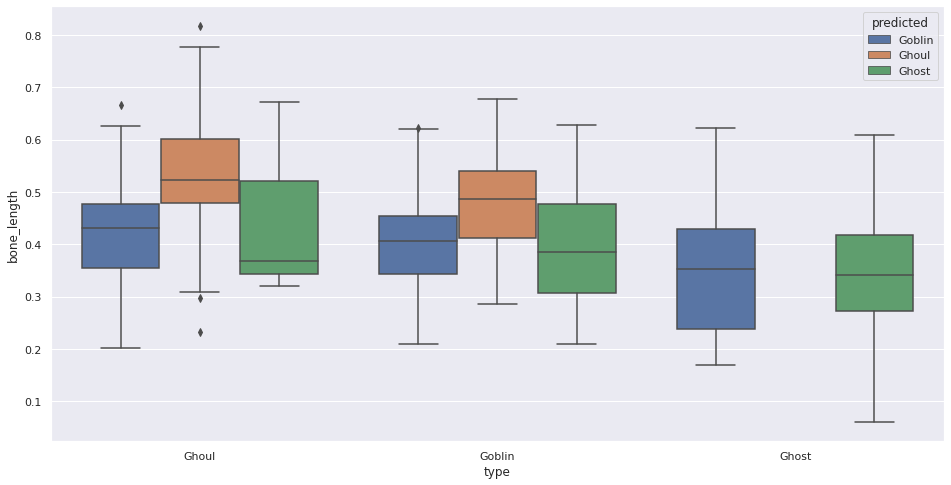

In [87]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

sns.boxplot(
    data=logreg_XyP,
    x="type",
    y="bone_length",
    hue="predicted",
    ax=ax
)

<AxesSubplot:xlabel='type', ylabel='bone_length'>

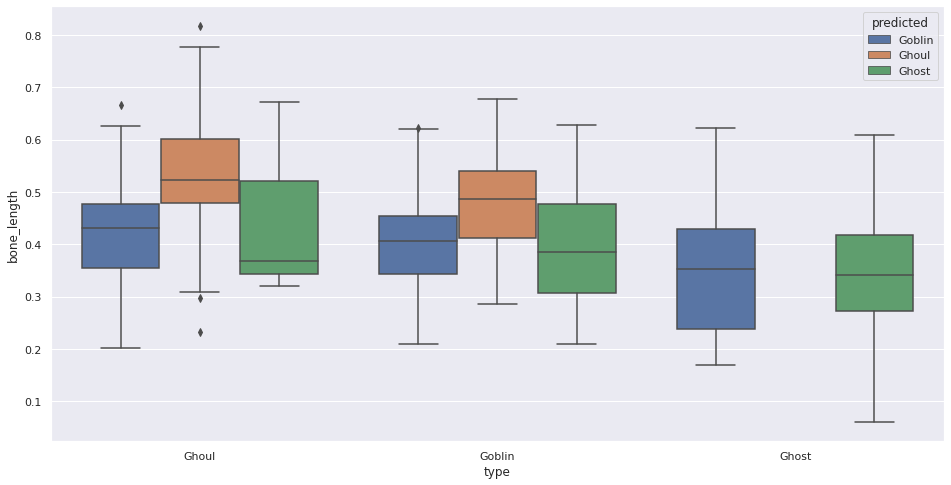

In [89]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

sns.boxplot(
    data=logreg_XyP,
    x="type",
    y="bone_length",
    hue="predicted",
    ax=ax
)

In [90]:
logreg_XyP['averages'] = np.mean([
    logreg_XyP.bone_length,
    logreg_XyP.rotting_flesh,
    logreg_XyP.hair_length,
    logreg_XyP.has_soul,
], axis=0)

logreg_XyP['medians'] = np.median([
    logreg_XyP.bone_length,
    logreg_XyP.rotting_flesh,
    logreg_XyP.hair_length,
    logreg_XyP.has_soul,
], axis=0)

<AxesSubplot:xlabel='type', ylabel='medians'>

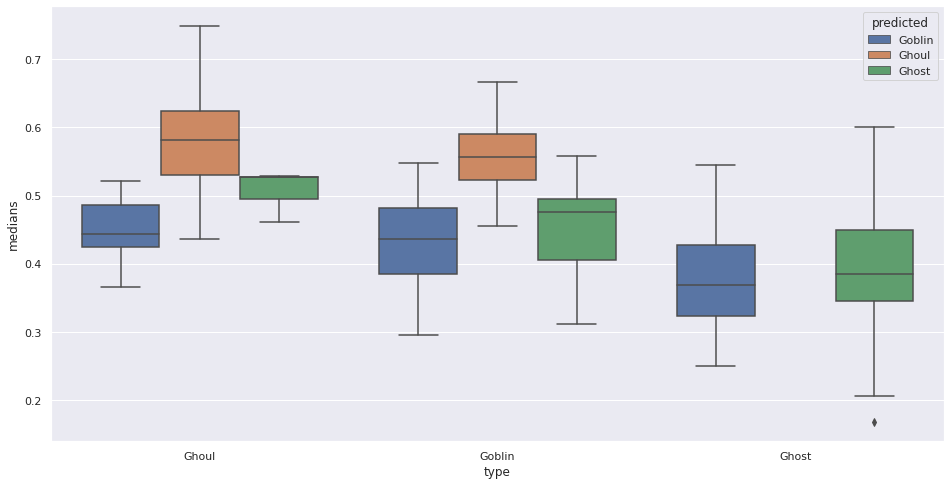

In [94]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

sns.boxplot(
    data=logreg_XyP,
    x="type",
    y="medians",
    hue="predicted",
    ax=ax
)